In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import rc, rcParams, font_manager 
#!find / -name "*Nanum*.ttf"
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf'
fontName = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=fontName)

import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option("display.max_columns", None)

In [ ]:
"""
R로 풀자!!! 


#help(ts)  # 시계열 데이터 생성 함수 도움말 
data <- read.csv('ldeaths.csv')
data <- ts(data$x, frequency = 12, start = c(1974, 1), end = c(1979, 12))  # frequency 12는 월, 4는 분기
data
plot(data)

#시계열분해 
data.decompose <- decompose(data)
data.decompose$seasonal

#계절조정(acf, pacf 확인시 필수 )
data.decompose.adj <- data - data.decompose$seasonal 
plot(data.decompose.adj)

# ARMA
acf(data.decompose.adj, lag.max=20) # MA 확인
acf(data.decompose.adj, lag.max=20, plot=FALSE)

pacf(data.decompose.adj, lag.max=20)  # AR 확인
pacf(data.decompose.adj, lag.max=20, plot=FALSE)

# AUTO ARIMA!!! 
auto.arima(data)

# 예측
library(forecast)
data.forecasts <- forecast(data.arima, h=12)
data.forecasts

plot(data.forecasts)


단, R로 시계열 데이터변환이 힘들거나, 
train/test 분리해야 하는 경우는 파이썬으로
"""

---
### ADP 교재 실습 데이터 

- (1) 나일강 연도별 강수량 데이터 (월별X)
- 1871년 ~ 1970년 

In [6]:
# 첫번째 인덱스 날리기 
nile = pd.read_csv('ADP_book_ver01/data/Nile.csv')[['x']]  
nile.tail()

,x
95,746
96,919
97,718
98,714
99,740


In [9]:
# 시계열 데이터 변환 
nile.set_index(pd.to_datetime(pd.Series(np.arange(1871, 1971)).apply(lambda x: str(x))), inplace=True)
nile.tail(3)

,x
1968-01-01,718
1969-01-01,714
1970-01-01,740


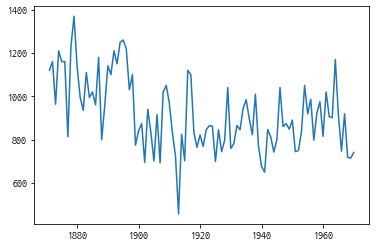

In [11]:
plt.plot(nile);

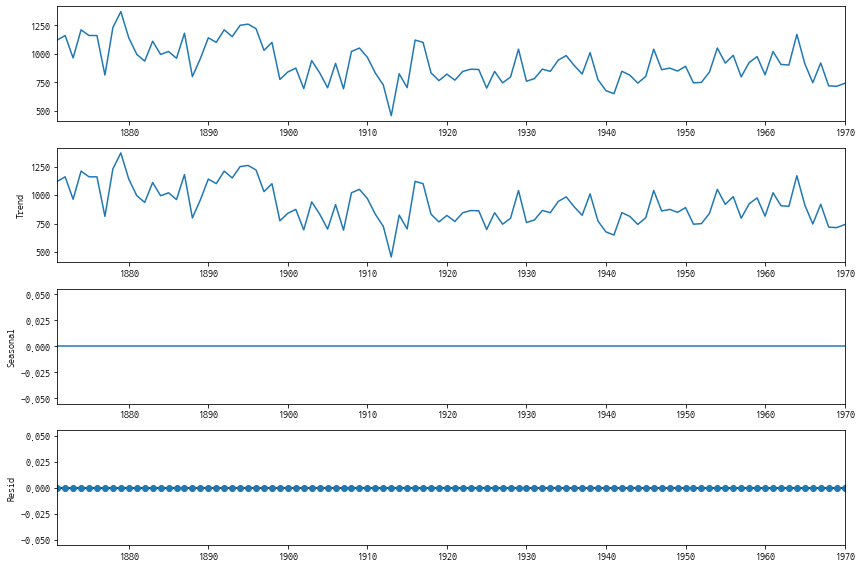

In [12]:
# 시계열분해 
from statsmodels.tsa.seasonal import seasonal_decompose 

res = seasonal_decompose(nile)
plt.rcParams['figure.figsize'] = [12,8]
res.plot();

다소 하향 추세, 계절성, 불규칙요인 모두 특이사항 없음 (연습용 데이터라 ...)

ADF통계량 :  -4.7907655179831234
ADF p-value :  0.0004861430290081328


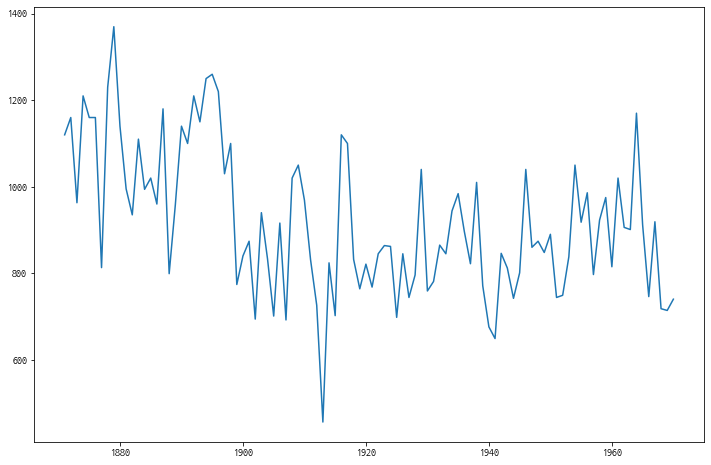

In [41]:
# 정상성 검증 ---> R교재에서는 생략
# H0 : 정상성을 갖지 않는다
from statsmodels.tsa.stattools import adfuller 

adf = adfuller(nile, regression='ct')  # 상수항+1차추세(기울기 약간 하락) 
print("ADF통계량 : ", adf[0])
print("ADF p-value : ", adf[1])  # H0 기각 => 정상성을 갖는다. 

plt.plot(nile);  

ADF통계량 :  -4.679734303955317
ADF p-value :  9.184725988911818e-05


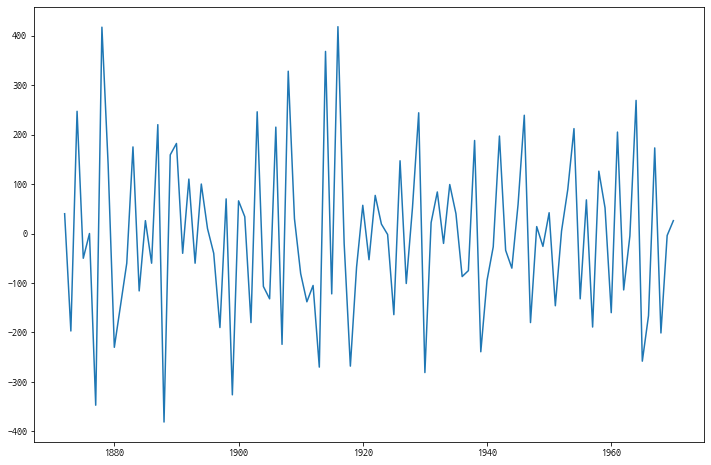

In [40]:
# 1차 차분 후 다시 검정 
diff_nile = nile.diff(1).dropna()

adf = adfuller(diff_nile, regression='c')  # 상수항 (추세 제거됨) 
print("ADF통계량 : ", adf[0])
print("ADF p-value : ", adf[1])  # H0 기각 => 정상성을 갖는다. p값 대폭 감소

plt.plot(diff_nile);  

ADF통계량 :  -4.912191486797449
ADF p-value :  3.30180240858094e-05


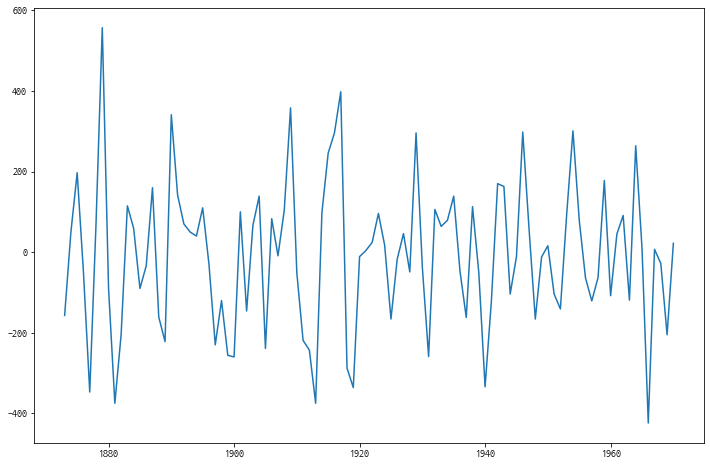

In [38]:
# 2차 차분 후 다시 검정 (교재와 동일)
diff_nile2 = nile.diff(2).dropna()

adf = adfuller(diff_nile2, regression='c')  # 상수항 (추세 제거됨) 
print("ADF통계량 : ", adf[0])
print("ADF p-value : ", adf[1])  # H0 기각 => 정상성을 갖는다. p값이 가장 작음. 가장 정상성 만족!!!

plt.plot(diff_nile2);  

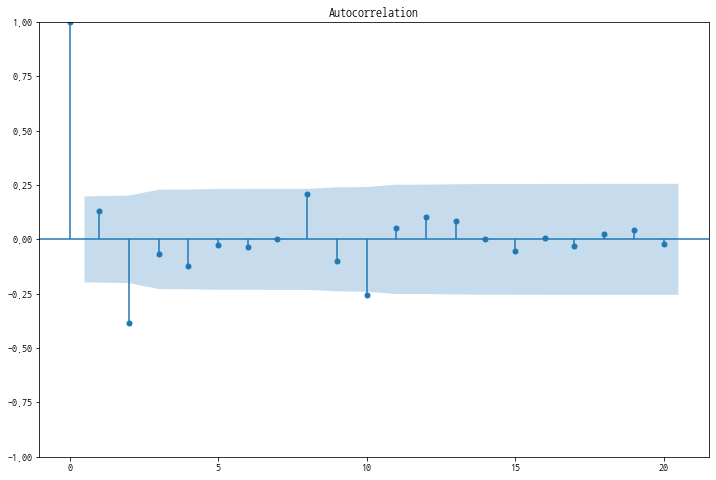

In [52]:
# ARMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(diff_nile2, lags=20) # MA 2 ??? 교재는 MA 1
plt.show()

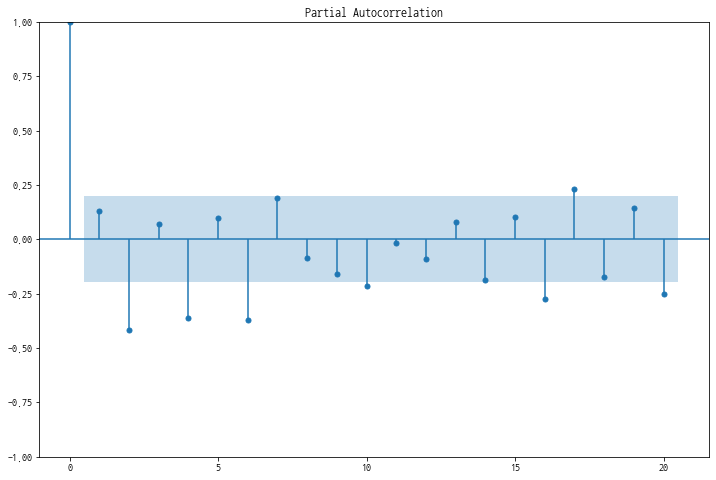

In [53]:
plot_pacf(diff_nile2, lags=20)
plt.show()  # AR 7 ??? 교재는 AR 8

In [54]:
# AUTO ARIMA
# !pip install pmdarima 
from pmdarima import auto_arima 

# 원본으로 돌리기(차분 전)
auto_model = auto_arima(nile, start_p=0, d=2, start_q=0, 
                        max_p=3, max_q=3, 
                        seasonal=False, information_criterin='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1387.573, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1341.111, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1385.573, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1317.277, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1310.396, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1308.399, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1315.277, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.794 seconds


In [55]:
# 원본으로 돌리기(차분 전)
auto_model = auto_arima(nile, start_p=0, d=1, start_q=0, 
                        max_p=3, max_q=3, 
                        seasonal=False, information_criterin='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1298.645, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1283.386, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1270.314, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1296.697, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1267.623, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1269.119, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1269.113, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1268.529, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1279.229, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1267.219, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1269.075, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1281.516, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1268.863, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [ ]:
>> ARIMA(3,2,0)(0,0,0)[0]             : AIC=1308.399, Time=0.03 sec
>> ARIMA(1,1,1)(0,0,0)[0]             : AIC=1267.219, Time=0.06 sec
    
ARIMA(1,1,1) 모델이 가장 적합!! (R auto.arima과 동일 결과)    

In [56]:
# 예측 및 차트
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -630.609
Date:                Mon, 21 Nov 2022   AIC                           1267.219
Time:                        10:12:55   BIC                           1275.004
Sample:                    01-01-1871   HQIC                          1270.369
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2549      0.129      1.981      0.048       0.003       0.507
ma.L1         -0.8749      0.055    -16.019      0.000      -0.982      -0.768
sigma2      1.977e+04   2831.135      6.982      0.000    1.42e+04    2.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.74   Prob(JB):                         0.92
Heteroskedasticity (H):               0.60   Skew:                            -0.10
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
pred_index = pd.to_datetime(pd.Series(np.arange(1971, 1971+10)).apply(lambda x: str(x)))
auto_pred_y = pd.DataFrame(auto_model.predict(10), index=pred_index)
auto_pred_y

,0
1971-01-01,816.30
1972-01-01,835.75
1973-01-01,840.71
1974-01-01,841.98
1975-01-01,842.30
1976-01-01,842.38
1977-01-01,842.40
1978-01-01,842.41
1979-01-01,842.41
1980-01-01,842.41


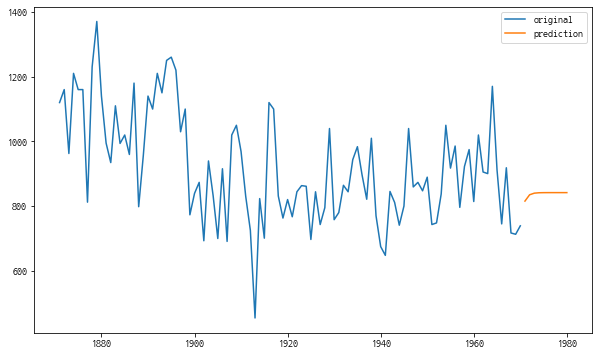

In [63]:
plt.figure(figsize=(10,6))
plt.plot(nile, label='original')
plt.plot(auto_pred_y, label='prediction')
plt.legend(loc='best')
plt.show()

---
- (2) 감기사망자 (월별, 계절추이)
- 1974년 1월 ~ 1979년 12월

In [95]:
ldeaths = pd.read_csv('ADP_book_ver01/data/ldeaths.csv')[['x']]
dt_idx = pd.date_range(start='1974-01-01', end='1980-01-01', freq='M')  # 월단위로 날짜를 만든다. end값 유의
ldeaths.set_index(dt_idx, inplace=True)
ldeaths.tail(3)

,x
1979-10-31,1492
1979-11-30,1781
1979-12-31,1915


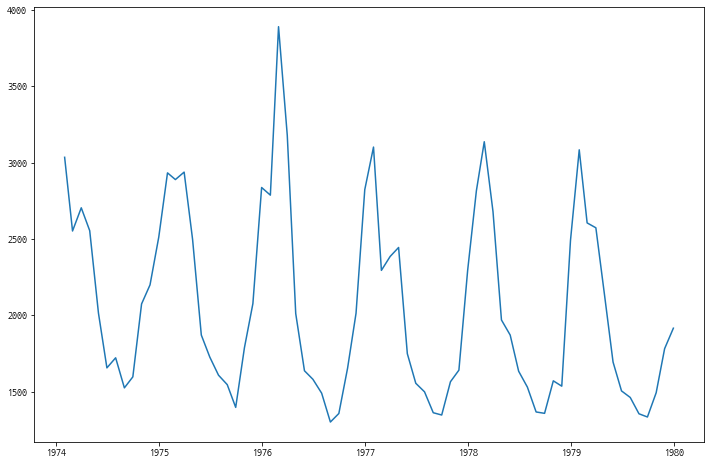

In [96]:
plt.plot(ldeaths);

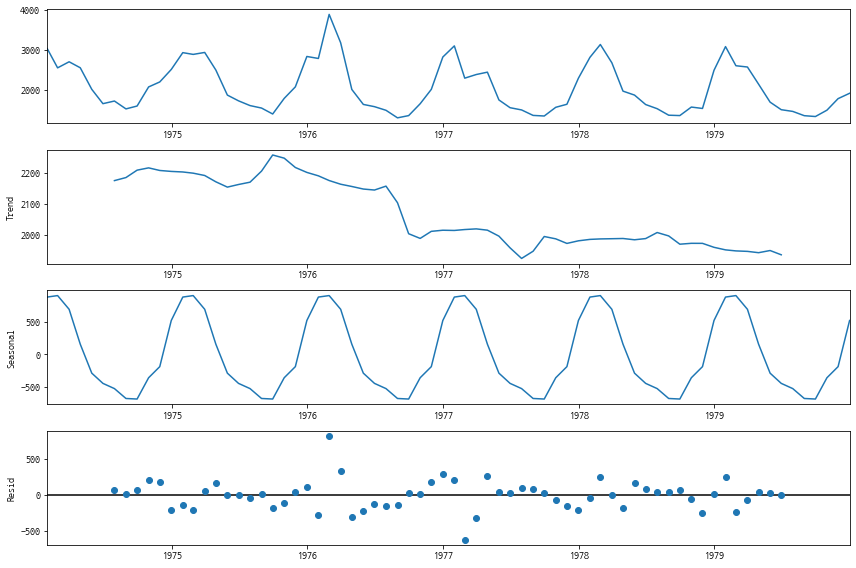

In [97]:
# 시계열분해 
from statsmodels.tsa.seasonal import seasonal_decompose 

res = seasonal_decompose(ldeaths)
plt.rcParams['figure.figsize'] = [12,8]
res.plot();

추세, 계절성, 불규칙성 모두 존재

ADF통계량 :  -6.3098468777021655
ADF p-value :  4.794117603572623e-07


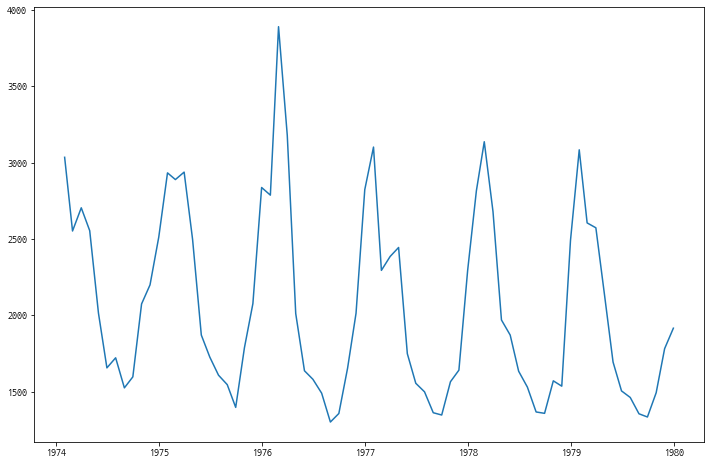

In [98]:
# 정상성 검증 ---> R교재에서는 생략
# H0 : 정상성을 갖지 않는다
from statsmodels.tsa.stattools import adfuller 

adf = adfuller(ldeaths, regression='ct')  # 상수항+1차추세(기울기 약간 하락) 
print("ADF통계량 : ", adf[0])
print("ADF p-value : ", adf[1])  # H0 기각 => 정상성을 갖는다. 
plt.plot(ldeaths);

ADF통계량 :  -6.781410830059206
ADF p-value :  2.4939938910348635e-09


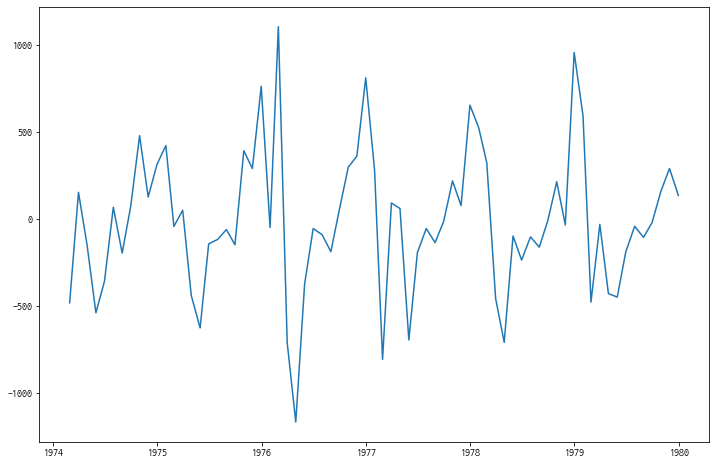

In [99]:
diff_ldeaths = ldeaths.diff(1).dropna()

adf = adfuller(diff_ldeaths, regression='c')  # 상수항 (추세 제거됨) 
print("ADF통계량 : ", adf[0])
print("ADF p-value : ", adf[1])  # H0 기각 => 정상성을 갖는다. p값 대폭 감소

plt.plot(diff_ldeaths);  

In [103]:
ldeaths

,x
1974-01-31,3035
1974-02-28,2552
1974-03-31,2704
1974-04-30,2554
1974-05-31,2014
...,...
1979-08-31,1354
1979-09-30,1333
1979-10-31,1492
1979-11-30,1781


In [104]:
res.seasonal   ###### 이것이 계절성

1974-01-31    873.75
1974-02-28    896.33
1974-03-31    687.54
1974-04-30    156.58
1974-05-31   -284.48
               ...  
1979-08-31   -669.87
1979-09-30   -678.22
1979-10-31   -354.31
1979-11-30   -185.21
1979-12-31    517.33
Freq: M, Name: seasonal, Length: 72, dtype: float64

In [105]:
res_decompose_adj =  ldeaths['x'] - res.seasonal     # 계절성 조정 후 ARMA 그리기
res_decompose_adj

1974-01-31   2,161.25
1974-02-28   1,655.67
1974-03-31   2,016.46
1974-04-30   2,397.42
1974-05-31   2,298.48
               ...   
1979-08-31   2,023.87
1979-09-30   2,011.22
1979-10-31   1,846.31
1979-11-30   1,966.21
1979-12-31   1,397.67
Freq: M, Length: 72, dtype: float64

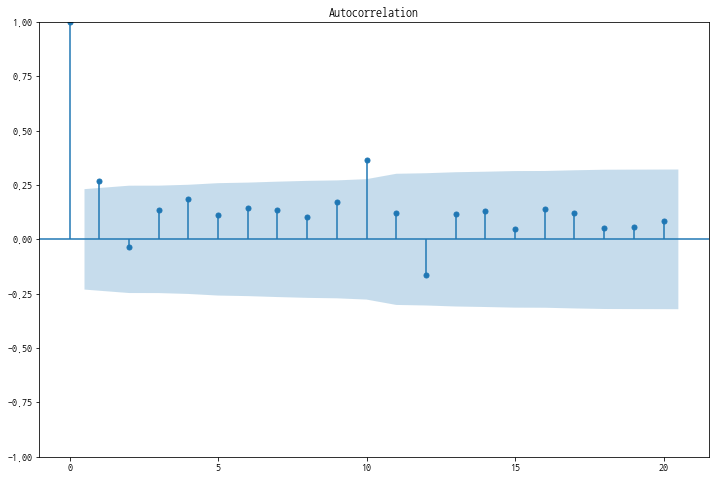

In [106]:
# ARMA : R교재와 동일하게 계절성 제거 후 플롯팅!!! 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

#plot_acf(diff_ldeaths, lags=20) # ----> XXXX 
plot_acf(res_decompose_adj, lags=20) # ---> 교재랑 똑같음
plt.show()

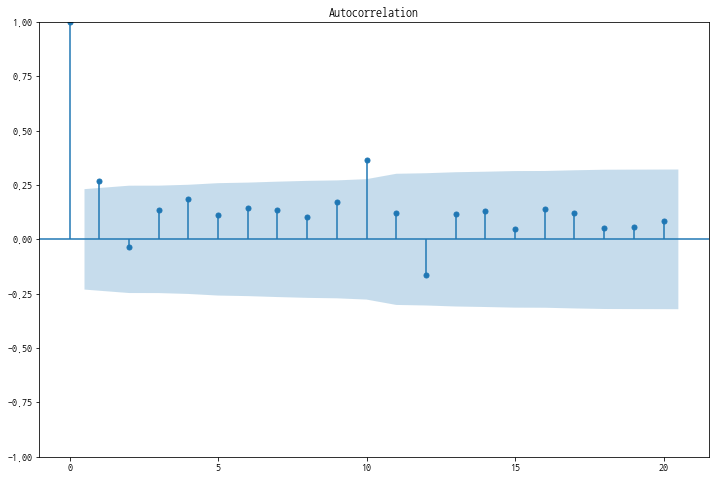

In [108]:
#plot_pacf(diff_ldeaths, lags=20) # MA 2 ??? 교재는 MA 1
plot_acf(res_decompose_adj, lags=20) # 교재와 약간 차이남
plt.show()

In [89]:
from pmdarima import auto_arima 

# 원본으로 돌리기(1차 차분 d=1)
auto_model = auto_arima(ldeaths, start_p=0, d=1, start_q=0, 
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=3, 
                        max_P=3, max_Q=3, m=12,
                        seasonal=True, information_criterin='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1059.820, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1055.676, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1056.893, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1057.925, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1056.498, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1044.348, Time=0.30 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1036.670, Time=0.87 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1043.470, Time=0.86 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1036.888, Time=0.71 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=1036.898, Time=1.92 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : 

In [90]:
# 예측 및 차트
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(3, 0, [1], 12)   Log Likelihood                -508.439
Date:                              Mon, 21 Nov 2022   AIC                           1032.878
Time:                                      10:45:08   BIC                           1050.980
Sample:                                  01-31-1974   HQIC                          1040.077
                                       - 12-31-1979                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.7468     24.542      0.601      0.548     -33.354      62.847
ar.L1         -0.2418      0.108     -2.235      0.025      -0.454      -0.030
ar.L2         -0.3032      0.096     -3.149      0.002      -0.492      -0.114
ar.S.L12      -0.5132      0.300     -1.711      0.087      -1.101       0.075
ar.S.L24       0.5408      0.072      7.508      0.000       0.400       0.682
ar.S.L36       0.7909      0.213      3.706      0.000       0.373       1.209
ma.S.L12       0.8622      2.606      0.331      0.741      -4.246       5.971
sigma2      5.253e+04   1.22e+05      0.431      0.667   -1.87e+05    2.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                70.90
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.13
Prob(H) (two-sided):                  0.80   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

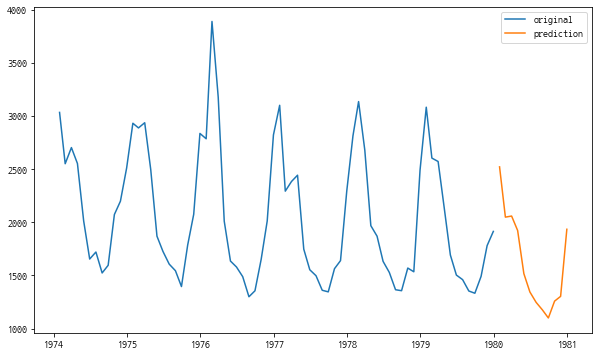

In [92]:
pred_index = pd.date_range(start='1980-01-01', periods=12, freq='M')  # 12개월치 날짜를 만든다. end값 유의
auto_pred_y = pd.DataFrame(auto_model.predict(12), index=pred_index)
#auto_pred_y

plt.figure(figsize=(10,6))
plt.plot(ldeaths, label='original')
plt.plot(auto_pred_y, label='prediction')
plt.legend(loc='best')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1130.822, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1056.532, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1069.408, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1310.864, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1069.196, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1040.137, Time=0.63 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=1048.984, Time=1.21 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1047.294, Time=0.54 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1055.622, Time=0.35 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1076.792, Time=0.55 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1047.630, Time=0.71 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1038.725, Time=0.70 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

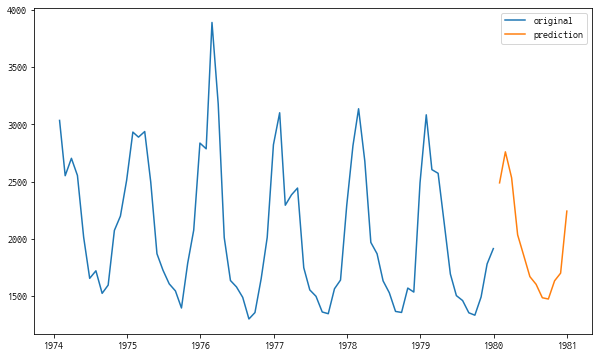

In [93]:
from pmdarima import auto_arima 

# 원본으로 돌리기(차분 안한 것 d=0)
auto_model = auto_arima(ldeaths, start_p=0, d=0, start_q=0, 
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=3, 
                        max_P=3, max_Q=3, m=12,
                        seasonal=True, information_criterin='aic', trace=True)

# auto_model.summary()

pred_index = pd.date_range(start='1980-01-01', periods=12, freq='M')  # 12개월치 날짜를 만든다. end값 유의
auto_pred_y = pd.DataFrame(auto_model.predict(12), index=pred_index)
#auto_pred_y

plt.figure(figsize=(10,6))
plt.plot(ldeaths, label='original')
plt.plot(auto_pred_y, label='prediction')
plt.legend(loc='best')
plt.show()